# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [1]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,614349,32.9,1331124,71.1,1143701,61.1
Vcells,1150876,8.8,8388608,64.0,1801047,13.8


Loading required package: data.table

Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: ‘checkmate’


The following object is masked from ‘package:DiceKriging’:

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [2]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

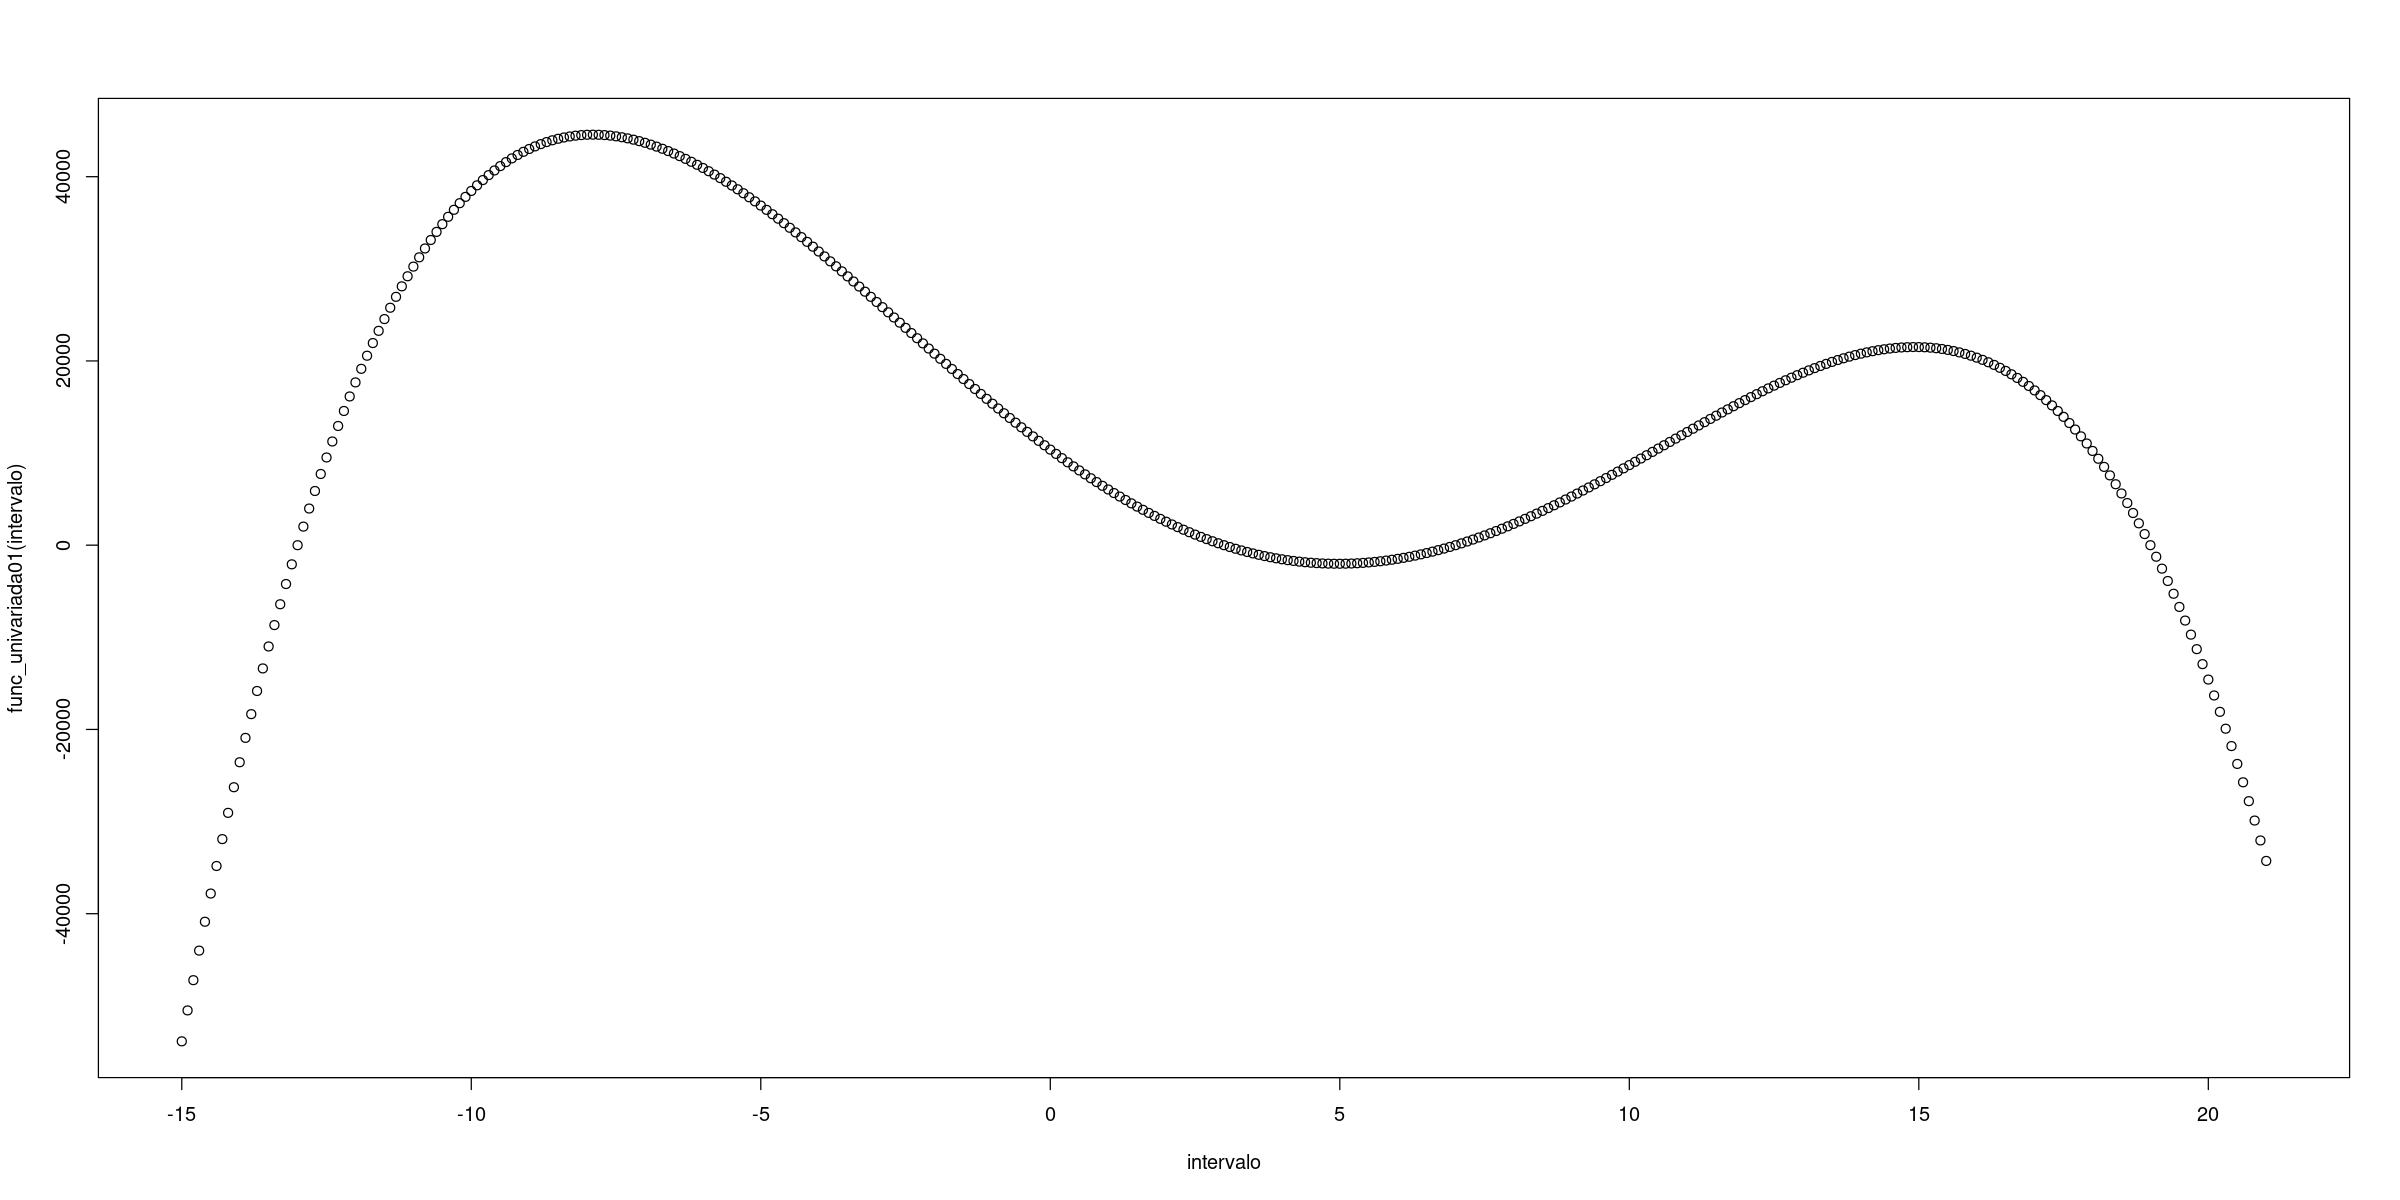

In [3]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [4]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [5]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [6]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [7]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=-49.7 : y = -1.51e+07 : 0.0 secs : initdesign

[mbo] 0: x=73.2 : y = -4.35e+07 : 0.0 secs : initdesign

[mbo] 0: x=22.6 : y = -7.79e+04 : 0.0 secs : initdesign

[mbo] 0: x=-82.2 : y = -1.06e+08 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -75.76741 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       75.767  |proj g|=     0.002502
At iterate     1  f =       75.767  |proj g|=      0.002497
At iterate     2  f =       75.766  |proj g|=    0.00068611
At iterate     3  f =       75.765  |proj g|=    0.00034104
At iterate     4  f =       75.765  |proj g|=    0.00014396
At iterate     5  f =       75.765  |proj g|=    6.6483e-05
At iterate     6  f =       75.765  |proj g|=    3.0253e-05
At iterate     7  f =       75.765  |proj g|=    1.4042e-05
At iterate     8  f =       75.765  |proj g|=      6.54e-06
At iterate     9  f =       75.765 

[mbo] 1: x=20.6 : y = -2.58e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -92.66218 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       92.662  |proj g|=   3.1726e-05
At iterate     1  f =       92.662  |proj g|=    3.1669e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.16691e-05
final function value 92.6622

F = 92.6622
final  value 92.662179 
converged


[mbo] 2: x=-22.4 : y = -5.79e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -110.9013 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        110.9  |proj g|=    0.0018422
At iterate     1  f =        110.9  |proj g|=     0.0018408
At iterate     2  f =        110.9  |proj g|=    0.00015318
At iterate     3  f =        110.9  |proj g|=      1.41e-05
At iterate     4  f =        110.9  |proj g|=    1.2173e-07

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.21731e-07
final function value 110.899

F = 110.899
final  value 110.898984 
conver

[mbo] 3: x=-2.11 : y = 2.14e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -128.1741 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       128.17  |proj g|=   0.00079549
At iterate     1  f =       128.17  |proj g|=    0.00079526
At iterate     2  f =       128.17  |proj g|=    4.6932e-05
At iterate     3  f =       128.17  |proj g|=    2.9787e-06
At iterate     4  f =       128.17  |proj g|=    1.2111e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.21112e-08
final function value 128.173

F = 128.173
final  value 128.172939 
conver

[mbo] 4: x=-33.4 : y = -3.15e+06 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -144.6616 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       144.66  |proj g|=   0.00021348
At iterate     1  f =       144.66  |proj g|=    0.00021345

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000213453
final function value 144.662

F = 144.662
final  value 144.661577 
converged


[mbo] 5: x=-11.8 : y = 2.01e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -160.4293 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       160.43  |proj g|=    0.0003604
At iterate     1  f =       160.43  |proj g|=    0.00036037

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000360367
final function value 160.429

F = 160.429
final  value 160.429315 
converged


[mbo] 6: x=8.66 : y = 4.21e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -176.0587 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       176.06  |proj g|=    0.0013564
At iterate     1  f =       176.06  |proj g|=     0.0013563
At iterate     2  f =       176.05  |proj g|=    0.00020466
At iterate     3  f =       176.05  |proj g|=    3.6924e-05
At iterate     4  f =       176.05  |proj g|=    1.2807e-06
At iterate     5  f =       176.05  |proj g|=    8.3748e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 8.3748e-09
final function

[mbo] 7: x=34.2 : y = -1.22e+06 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -192.4699 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       192.47  |proj g|=   0.00012949
At iterate     1  f =       192.47  |proj g|=    0.00012949

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000129489
final function value 192.47

F = 192.47
final  value 192.469948 
converged


[mbo] 8: x=14.3 : y = 2.12e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -207.042 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       207.04  |proj g|=   0.00056957
At iterate     1  f =       207.04  |proj g|=    0.00056955

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000569547
final function value 207.042

F = 207.042
final  value 207.041987 
converged


[mbo] 9: x=3.1 : y = -195 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -221.4456 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       221.45  |proj g|=   9.4861e-05
At iterate     1  f =       221.45  |proj g|=    9.4858e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 9.48585e-05
final function value 221.446

F = 221.446
final  value 221.445643 
converged


[mbo] 10: x=-7.14 : y = 4.39e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -235.6517 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       235.65  |proj g|=    9.733e-05
At iterate     1  f =       235.65  |proj g|=    9.7328e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 9.73278e-05
final function value 235.652

F = 235.652
final  value 235.651707 
converged


[mbo] 11: x=28 : y = -3.9e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -250.079 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       250.08  |proj g|=   0.00014841
At iterate     1  f =       250.08  |proj g|=    0.00014841

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000148406
final function value 250.079

F = 250.079
final  value 250.078984 
converged


[mbo] 12: x=-16.4 : y = -1.1e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -264.2661 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       264.27  |proj g|=   0.00073987
At iterate     1  f =       264.27  |proj g|=    0.00073985

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000739848
final function value 264.266

F = 264.266
final  value 264.266147 
converged


[mbo] 13: x=17.2 : y = 1.58e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -277.663 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       277.66  |proj g|=    0.0016732
At iterate     1  f =       277.66  |proj g|=     0.0016732
At iterate     2  f =       277.64  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 277.639

F = 277.639
final  value 277.638862 
converged


[mbo] 14: x=-4.7 : y = 3.54e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -290.7653 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       290.77  |proj g|=    0.0021653
At iterate     1  f =       290.77  |proj g|=     0.0021653
At iterate     2  f =       290.74  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 290.741

F = 290.741
final  value 290.740680 
converged


[mbo] 15: x=11.5 : y = 1.39e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -304.0734 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       304.07  |proj g|=    0.0043413
At iterate     1  f =       304.07  |proj g|=      0.004341
At iterate     2  f =       303.93  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 303.929

F = 303.929
final  value 303.928602 
converged


[mbo] 16: x=-9.48 : y = 4.13e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -316.8354 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       316.84  |proj g|=     0.003139
At iterate     1  f =       316.84  |proj g|=     0.0031388
At iterate     2  f =       316.82  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 316.819

F = 316.819
final  value 316.818821 
converged


[mbo] 17: x=5.82 : y = -1.65e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -329.9735 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       329.97  |proj g|=    0.0040455
At iterate     1  f =       329.97  |proj g|=     0.0040453
At iterate     2  f =       329.93  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 329.928

F = 329.928
final  value 329.928408 
converged


[mbo] 18: x=0.421 : y = 8.46e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -342.9199 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       342.92  |proj g|=    0.0046639
At iterate     1  f =       342.92  |proj g|=     0.0046637
At iterate     2  f =       342.87  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 342.869

F = 342.869
final  value 342.869044 
converged


[mbo] 19: x=-13.8 : y = -1.93e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -355.7226 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       355.72  |proj g|=    0.0054871
At iterate     1  f =       355.72  |proj g|=     0.0054868
At iterate     2  f =       355.65  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 355.647

F = 355.647
final  value 355.646592 
converged


[mbo] 20: x=-8.29 : y = 4.44e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -367.4836 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       367.48  |proj g|=     0.005572
At iterate     1  f =       367.48  |proj g|=     0.0055717
At iterate     2  f =       367.45  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 367.454

F = 367.454
final  value 367.454221 
converged


[mbo] 21: x=-5.93 : y = 4.07e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -379.2497 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       379.25  |proj g|=    0.0058856
At iterate     1  f =       379.25  |proj g|=     0.0058853
At iterate     2  f =       379.25  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 379.248

F = 379.248
final  value 379.247602 
converged


[mbo] 22: x=15.7 : y = 2.09e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -391.4994 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        391.5  |proj g|=    0.0078687
At iterate     1  f =        391.5  |proj g|=     0.0078681
At iterate     2  f =       391.35  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 391.35

F = 391.35
final  value 391.349862 
converged


[mbo] 23: x=-3.43 : y = 2.88e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -403.4005 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        403.4  |proj g|=    0.0090351
At iterate     1  f =        403.4  |proj g|=     0.0090343
At iterate     2  f =       403.19  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 403.185

F = 403.185
final  value 403.185478 
converged


[mbo] 24: x=18.8 : y = 2.69e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -415.3896 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       415.39  |proj g|=     0.007873
At iterate     1  f =       415.39  |proj g|=     0.0078724
At iterate     2  f =       415.36  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 415.362

F = 415.362
final  value 415.362296 
converged


[mbo] 25: x=12.9 : y = 1.84e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  310.8679 
  - best initial criterion value(s) :  -427.4475 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       427.45  |proj g|=    0.0094905
At iterate     1  f =       427.45  |proj g|=     0.0094897
At iterate     2  f =        427.3  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 427.303

F = 427.303
final  value 427.303103 
converged


In [ ]:
tb_resultados  <- as.data.table( run$opt.path )

In [ ]:
tb_resultados

In [ ]:
tb_resultados[ which.max( tb_resultados$y ) ]

### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?